In [2]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest
import math
import matplotlib.pyplot as plot
from scipy.stats import anderson

def check_unique(x):
    x = sorted([math.ceil(number) for number in x])
    is_unique = len(x) == len(set(x))
    return is_unique

def beluga_whale_optimization(fitness_function, bounds, population_size, generations, number_of_whales):
    global target_score

    # initialize population
    population = np.random.uniform(bounds[0][0], bounds[0][1], size = (number_of_whales, population_size))

    # initialize best position and score
    best_position = None
    best_score = float('inf')

    # iterate over generations
    for i in range(generations):
        # evaluate fitness of each whale
        scores = np.array([fitness_function(p) for p in population])

        # update best position and score
        if np.min(scores) < best_score:
            best_position = population[np.argmin(scores)]
            best_score = np.min(scores)

        # calculate a and c parameters
        a = 2 - i * (2 / generations)
        c = 2 * np.random.uniform()

        # iterate over whales
        for j in range(population_size):
            # calculate distance to best position
            distance_to_best = np.linalg.norm(population[j] - best_position)

            # update position of whale
            if np.random.uniform() < 0.5:
                # apply Levy flight and sine cosine
                r = np.random.rand()
                l = levy_flight(len(bounds))
                s = np.sin(2 * np.pi * r)
                c = np.cos(2 * np.pi * r)
                new_position = best_position - a * distance_to_best + l * s + c * population[j] * c
            else:
                new_position = population[np.random.randint(population_size)] - a * distance_to_best + c * np.random.uniform(bounds[0][0], bounds[0][1], len(bounds))

            # clip new position to bounds
            new_position = np.clip(new_position, bounds[0][0], bounds[0][1])

            # update population with new position
            population[j] = new_position

        if best_score <= target_score:
            return best_position, best_score

    return best_position, best_score

def levy_flight(dim):
    """Generate a Levy flight vector.
    Args:
    dim: The number of dimensions.

    Returns:
    The Levy flight vector.
    """

    # Initialize the vector.
    v = np.zeros(dim)

    # Generate the steps.
    steps = np.random.rand(dim) * 2 - 1

    # Calculate the increments.
    increments = steps * (np.power(np.abs(steps), 0.5 + 1 / dim) - 1)

    # Update the vector.
    v = v + increments

    return v

def fitness_function(x):
    global target_difficulty
    global target_frequency
    global target_distractor
    global difficulties
    global frequencies
    global distractors
    global population_size
    global mean_difficulty
    global std_dev_difficulty
    global fitness_for_distribution
    #global normal_difficulties
    global iqr_qbank

    x = [math.ceil(number) for number in x]
    #print(x)
    #x = int(x)
    fit_diff, fit_freq, fit_dist = 0, 0, 0
    total_fit = 0

    candidate_diff = []
    for item in range(len(x)):
        fit_diff += (difficulties[x[item]] - target_difficulty)
        fit_freq += (frequencies[x[item]] - target_frequency)
        fit_dist += (distractors[x[item]] - target_distractor)
        candidate_diff.append(difficulties[x[item]])

    if not(fitness_for_distribution):
        fitness = abs(fit_diff/population_size) + abs(fit_freq/population_size) + abs(fit_dist/population_size)
    else:
        #ks_statistic, p_value = ks_2samp(difficulties, candidate_diff)
        #print(candidate_diff)
        mean_candidate = np.mean(candidate_diff)
        stddev_candidate = np.std(candidate_diff)
        fitness = abs(mean_difficulty - mean_candidate) + abs(std_dev_difficulty - stddev_candidate)*1.5
        fitness += abs(iqr_qbank - (np.percentile(candidate_diff, 75) - np.percentile(candidate_diff, 25)))
    #bunlarda çarpan şeklinde ceza uygulanabilir
    return fitness

def read_csv(file):
    import csv

    with open(file, 'r') as file:
        reader = csv.reader(file)
        cols1, cols2, cols3 = [], [], []
        for row in reader:
            col1, col2, col3 = row
            col1 = float(col1)
            col2 = float(col2)
            col3 = float(col3)
            cols1.append(col1)
            cols2.append(col2)
            cols3.append(col3)
    return cols1, cols2, cols3

if __name__ == "__main__":

    difficulties, frequencies, distractors = read_csv('ornekdegerler.csv')

    mean_difficulty = np.mean(difficulties)
    std_dev_difficulty = np.std(difficulties)

    bounds = [(0, len(difficulties)-1)]
    population_size = 50
    number_of_whales = 10000
    generations = 1000
    target_difficulty = 0.6
    target_frequency = 0
    target_distractor = 0.3
    target_score = 1 #best <---- 5e-3

    fitness_for_distribution = True

    iqr_qbank = np.percentile(difficulties, 75) - np.percentile(difficulties, 25)


    # beluga_whale_optimization(fitness_function, bounds, population_size, generations)
    best_position, best_score = beluga_whale_optimization(fitness_function, bounds, population_size, generations, number_of_whales)
    #print("Best whale    =", best_whale)

    is_unique = check_unique(best_position)

    max_trial = 3
    cur_trial = 0

    while not(is_unique):
        print("Warning: best_position is not unique, re-run...")
        best_position, best_score = beluga_whale_optimization(fitness_function, bounds, population_size, generations, number_of_whales)
        is_unique = check_unique(best_position)
        cur_trial += 1
        if cur_trial >= max_trial:
            print("max trials reached, exiting")
            break

    best_position = sorted([math.ceil(number) for number in best_position])
    if fitness_for_distribution:
        print("Priority: distribution similarity")
    else:
        print("Priority: target parameters")
    print("-------")
    print("Best score                          =", best_score)
    print("Best position                       =", best_position)
    print("")
    print("Question bank average difficulty    =", mean_difficulty)
    print("Question bank standard deviation    =", std_dev_difficulty)
    print("")
    best_diff = []
    for item in best_position:
        best_diff.append(difficulties[item])
    best_mean = np.mean(best_diff)
    best_stddev = np.std(best_diff)

    print("Exam average difficulty             =", best_mean)
    print("Exam standard deviation             =", best_stddev)
    print("")
    ks_statistic, p_value = kstest(difficulties, best_diff)
    print("Kolmogorov-Smirnov statistic    =", ks_statistic)
    print("p value                         =", p_value)
    print("----")
    anderson_stat1, anderson_criticals1, anderson_p_value1 = anderson(difficulties)
    anderson_stat2, anderson_criticals2, anderson_p_value2= anderson(best_diff)

    print("Anderson-Darling test for question bank : ")
    print("statistic = %f" % anderson_stat1)
    print("critical values =", anderson_criticals1)
    print("p-value = ", anderson_p_value1)

    print("Anderson-Darling test for selected data :")
    print("statistic = %f" % anderson_stat2)
    print("critical values =", anderson_criticals2)
    print("p-value = ", anderson_p_value2)
    print("----")
    iqr_exam = np.percentile(best_diff, 75) - np.percentile(best_diff, 25)
    iqr = abs(iqr_qbank - iqr_exam)
    print("Interquartile range difference          =", iqr)
    print("***")

Priority: distribution similarity
-------
Best score                          = 0.0029451351953109217
Best position                       = [107, 233, 461, 893, 1533, 1625, 1920, 2124, 2274, 2309, 2725, 2827, 2844, 2894, 3299, 3394, 3954, 4261, 4569, 4603, 4611, 4669, 5195, 5327, 5937, 6206, 6405, 7708, 7748, 7779, 8339, 8476, 8570, 8813, 8814, 8835, 8962, 8975, 9475, 9665, 9778, 10303, 10315, 10738, 10745, 11046, 11241, 11339, 11562, 11633]

Question bank average difficulty    = 0.6905384452584452
Question bank standard deviation    = 0.20315856516350025

Exam average difficulty             = 0.6904300000000001
Exam standard deviation             = 0.20323302512141084

Kolmogorov-Smirnov statistic    = 0.08726902726902719
p value                         = 0.8091831303532437
----
Anderson-Darling test for question bank : 
statistic = 126.162906
critical values = [0.576 0.656 0.787 0.918 1.092]
p-value =  [15.  10.   5.   2.5  1. ]
Anderson-Darling test for selected data :
statistic = 0

from google.colab import drive
drive.mount('/content/drive')

In [3]:
d1=0
d2=0
d3=0
diff_plot=[]
for i in range(len(best_position)):
    print(difficulties[best_position[i]], ' ', frequencies[best_position[i]], ' ', distractors[best_position[i]])
    diff_plot.append(difficulties[best_position[i]])
    d1+=difficulties[best_position[i]]
    d2+=frequencies[best_position[i]]
    d3+=distractors[best_position[i]]
dd1=d1/population_size
dd2=d2/population_size
dd3=d3/population_size
print(dd1, ' ',dd2, ' ', dd3)
print(target_difficulty, ' ', target_frequency, ' ', target_distractor)
diff_plot=sorted(diff_plot)

0.1463   0.0   0.0488
0.2045   0.0   -0.0455
0.2744   0.0   0.2561
0.3598   0.0   0.1585
0.4337   0.0   0.4578
0.4416   0.0   0.3896
0.4702   0.0   0.2738
0.4878   0.0   0.439
0.5   0.0   0.6098
0.5   0.0   0.6
0.5349   0.0   0.3953
0.5427   0.0   0.4512
0.5432   0.0   0.5679
0.5461   0.0   0.5658
0.5696   0.0   0.4304
0.575   0.0   0.45
0.6084   0.0   0.494
0.625   0.0   0.15
0.6439   0.0   0.3788
0.6458   0.0   0.5694
0.6463   0.0   0.3659
0.65   0.0   0.7
0.6765   0.0   0.2941
0.6824   0.0   0.2568
0.7105   0.0   0.2632
0.725   0.0   0.55
0.7326   0.0   0.2326
0.7917   0.0   0.131
0.7929   0.0   0.3286
0.7949   0.0   0.3846
0.8182   0.0   0.3117
0.8243   0.0   0.3243
0.8258   0.0   0.3182
0.8355   0.0   0.3289
0.8355   0.0   0.3289
0.8372   0.0   0.2791
0.8434   0.0   0.1928
0.8452   0.0   0.2857
0.8643   0.0   0.2143
0.8734   0.0   0.0
0.8788   0.0   0.2424
0.9012   0.0   0.1047
0.9013   0.0   0.1184
0.9198   0.0   0.1111
0.92   0.0   0.0533
0.9337   0.0   0.0843
0.9419   0.0   0.0

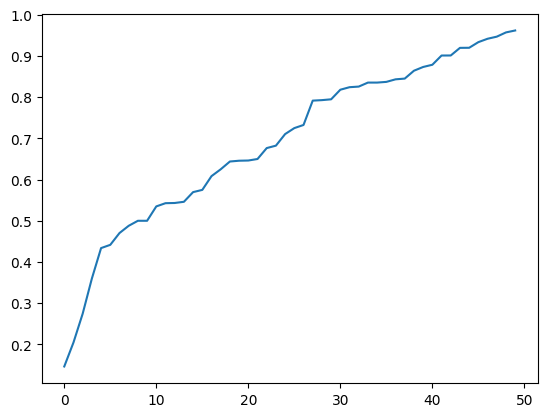

In [4]:
plot.plot(diff_plot)

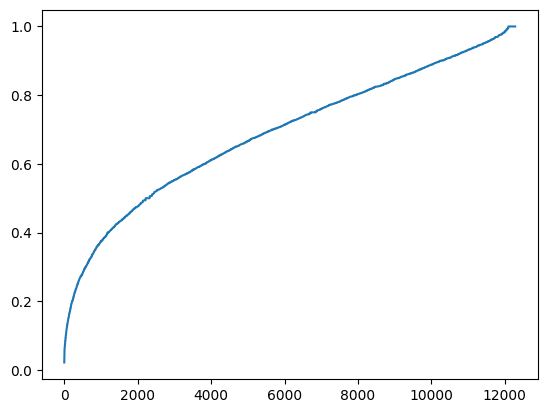

In [5]:
plot.plot(difficulties)

(array([  66.,  197.,  396.,  664., 1069., 1569., 1884., 2194., 2302.,
        1944.]),
 array([0.0217 , 0.11953, 0.21736, 0.31519, 0.41302, 0.51085, 0.60868,
        0.70651, 0.80434, 0.90217, 1.     ]),
 <BarContainer object of 10 artists>)

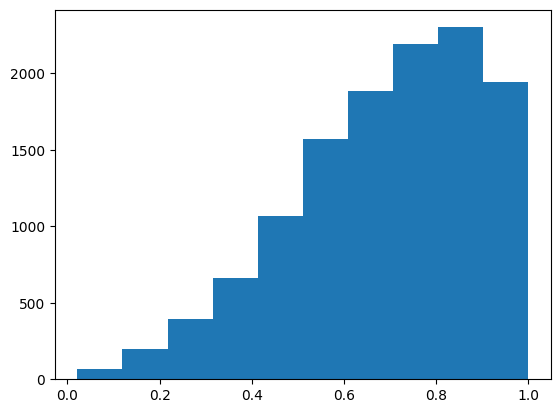

In [6]:
plot.hist(difficulties)